# Dependencias

In [1]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
from datetime import date,datetime
from dateutil.relativedelta import relativedelta as rd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.feature_selection import SelectKBest
from scipy import stats
from varclushi import VarClusHi
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler


from functools import reduce
import os

cf.go_offline()

# Planteamiento del Problema

Crear un modelo para predecir la descompostura o fin de vida útil de las bicicletas  
La unidad muestral son las bicis y construiremos la target   
El intervalo de observación será de 3 semanas.

# Lectura de Datos

In [2]:
ruta = '/home/rodolfo/Documentos/Modelos/ECO-BICI/'
ruta

'/home/rodolfo/Documentos/Modelos/ECO-BICI/'

In [3]:
rutas = [os.path.join(ruta,x) for x in os.listdir(ruta) if x[0] == '2']
rutas

['/home/rodolfo/Documentos/Modelos/ECO-BICI/2018-05.csv',
 '/home/rodolfo/Documentos/Modelos/ECO-BICI/2018-12.csv',
 '/home/rodolfo/Documentos/Modelos/ECO-BICI/2018-09.csv',
 '/home/rodolfo/Documentos/Modelos/ECO-BICI/2018-10.csv',
 '/home/rodolfo/Documentos/Modelos/ECO-BICI/2018-04.csv',
 '/home/rodolfo/Documentos/Modelos/ECO-BICI/2018-01.csv',
 '/home/rodolfo/Documentos/Modelos/ECO-BICI/2018-03.csv',
 '/home/rodolfo/Documentos/Modelos/ECO-BICI/2018-02.csv',
 '/home/rodolfo/Documentos/Modelos/ECO-BICI/2018-06.csv',
 '/home/rodolfo/Documentos/Modelos/ECO-BICI/2018-11.csv',
 '/home/rodolfo/Documentos/Modelos/ECO-BICI/2018-08.csv',
 '/home/rodolfo/Documentos/Modelos/ECO-BICI/2018-07.csv']

In [4]:
unir = lambda x,y:pd.concat([x,y], ignore_index =True)
datf = lambda x:pd.read_csv(x)

In [5]:
df = reduce(unir,map(datf, rutas))
df.head()

/tmp/ipykernel_5758/862667603.py:1: DtypeWarning:

Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.



,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo
0,M,32,10060,236,01/05/2018,0:00:52,215,01/05/2018,0:03:42
1,M,22,10292,5,01/05/2018,0:00:53,112,01/05/2018,0:42:52
2,F,23,3488,15,01/05/2018,0:00:54,31,01/05/2018,0:10:10
3,M,30,2978,435,01/05/2018,0:01:05,396,01/05/2018,0:04:10
4,M,27,10256,15,01/05/2018,0:01:06,31,01/05/2018,0:10:07


# Limpieza de datos

In [6]:
for i in ['Retiro','Arribo']:
    df[f'Fecha_{i}'] = pd.to_datetime(df[f'Fecha_{i}'] + ' ' + df[f'Hora_{i}'], 
                                   format='%d/%m/%Y %H:%M:%S',
                                   errors='coerce')
    df.drop([f'Hora_{i}'], axis =1, inplace = True)

In [7]:
df.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo
0,M,32,10060,236,2018-05-01 00:00:52,215,2018-05-01 00:03:42
1,M,22,10292,5,2018-05-01 00:00:53,112,2018-05-01 00:42:52
2,F,23,3488,15,2018-05-01 00:00:54,31,2018-05-01 00:10:10
3,M,30,2978,435,2018-05-01 00:01:05,396,2018-05-01 00:04:10
4,M,27,10256,15,2018-05-01 00:01:06,31,2018-05-01 00:10:07


## Definición de Variables

In [8]:
um = ['Bici']
var = ['Fecha_Arribo', 'Fecha_Retiro']
df = df[um + var].copy()
df

,Bici,Fecha_Arribo,Fecha_Retiro
0,10060,2018-05-01 00:03:42,2018-05-01 00:00:52
1,10292,2018-05-01 00:42:52,2018-05-01 00:00:53
2,3488,2018-05-01 00:10:10,2018-05-01 00:00:54
3,2978,2018-05-01 00:04:10,2018-05-01 00:01:05
4,10256,2018-05-01 00:10:07,2018-05-01 00:01:06
...,...,...,...
8540253,4311,2018-07-31 00:05:55,2018-07-30 23:57:39
8540254,11031,2018-07-31 00:19:04,2018-07-30 23:58:31
8540255,11277,2018-07-31 00:03:21,2018-07-30 23:59:06
8540256,7188,2018-07-31 00:10:42,2018-07-30 23:59:10


# Ingeniería de Datos

In [9]:
#Número de días sin utilizarse
#Número de viajes realizados
#Promedio de tiempo de uso
#Veces promedio que se usa la bici por mes
#Número de viajes en fin de semana
#Pct de viajes en fin de semana
#viajes por día

In [10]:
dias = dict(zip(range(1,8), 'LMXJVSD'))

df['finde'] = df['Fecha_Arribo'].map(lambda x:x.weekday() in [6,7]).astype(int) 
df['dia'] = df['Fecha_Arribo'].map( lambda x:x.weekday()).replace(dias)

In [11]:
df.head()

,Bici,Fecha_Arribo,Fecha_Retiro,finde,dia
0,10060,2018-05-01 00:03:42,2018-05-01 00:00:52,0,L
1,10292,2018-05-01 00:42:52,2018-05-01 00:00:53,0,L
2,3488,2018-05-01 00:10:10,2018-05-01 00:00:54,0,L
3,2978,2018-05-01 00:04:10,2018-05-01 00:01:05,0,L
4,10256,2018-05-01 00:10:07,2018-05-01 00:01:06,0,L


In [12]:
df['AñoMes'] = df['Fecha_Arribo'].map(lambda x:x.strftime('%Y%m'))

In [13]:
np.sort(df['AñoMes'].unique())

array(['201801', '201802', '201803', '201804', '201805', '201806',
       '201807', '201808', '201809', '201810', '201811', '201812'],
      dtype=object)

La ventana de Observación será de 4 meses y la ventana de desempeño de 1 mes

In [14]:
vobs, vdes = 4, 1

In [15]:
def diasSinUsar(df:pd.DataFrame,ancla:str)->pd.DataFrame:
    ancla = date(int(ancla[:4]),int(ancla[4:]),1) # convertimos el ancla en tipo fecha, año,mes y 1 es el día 
    anclas = [(ancla+rd(months=-i)).strftime('%Y%m') for i in range(vobs)]#Sacamos las anclas de ancla-0meses, ancla-1mes,ancla-2meses, ancla-3meses
    aux = df.loc[df['AñoMes'].isin(anclas)].copy().reset_index(drop=True) #ventana de observación de 4 meses 
    aux['dia'] = pd.to_datetime(aux['Fecha_Retiro']).dt.date #EXtraigo Año mes y día solamente y lo agrego como columan a aux 
    aux = aux.pivot_table(index='Bici',columns='dia',values='AñoMes',aggfunc='count',fill_value=0) #cuántas veces se usó la bici en un mes, es necesario fill_value pues quedan missings
    aux = aux.apply(lambda x:x==0).astype(int) #Si se usó la bici se pone un 1 si no un 0 
    aux['x_num_dias_sin_uso_ult_4m'] = aux.sum(axis=1) # las que no se usaron en los últimos 4 meses, hacemos una suma horizontal
    return aux.filter(like='x_').reset_index().assign(ancla=ancla)

In [16]:
def numViajes(df:pd.DataFrame,ancla:str)->pd.DataFrame:
    ancla = date(int(ancla[:4]),int(ancla[4:]),1) # convertimos el ancla en tipo fecha, año,mes y 1 es el día 
    anclas = [(ancla+rd(months=-i)).strftime('%Y%m') for i in range(vobs)]#Sacamos las anclas de ancla-0meses, ancla-1mes,ancla-2meses, ancla-3meses
    aux = df.loc[df['AñoMes'].isin(anclas)].copy().reset_index(drop=True) #ventana de observación de 4 meses 
    aux = aux.groupby(['Bici']).count()[['AñoMes']] 
    aux['x_num_viajes_ult_4m'] = aux[['AñoMes']] 
    return aux.filter(like='x_').reset_index().assign(ancla=ancla)

In [17]:
def promTiempoUso(df:pd.DataFrame,ancla:str)->pd.DataFrame:
    ancla = date(int(ancla[:4]),int(ancla[4:]),1)
    anclas = [(ancla+rd(months=-i)).strftime('%Y%m') for i in range(vobs)]
    aux = df.loc[df['AñoMes'].isin(anclas)].copy().reset_index(drop=True)
    aux['duracion'] = (aux['Fecha_Arribo']-aux['Fecha_Retiro'])/np.timedelta64(1,'m')
    aux = aux.groupby(['Bici']).mean()[['duracion']]
    aux.columns = ['x_duracion_prom_viaje_ult_4m']
    return aux.filter(like='x_').reset_index().assign(ancla=ancla)

In [18]:
def vecesPromDia(df:pd.DataFrame,ancla:str)->pd.DataFrame:
    ancla = date(int(ancla[:4]),int(ancla[4:]),1)
    anclas = [(ancla+rd(months=-i)).strftime('%Y%m') for i in range(vobs)]
    aux = df.loc[df['AñoMes'].isin(anclas)].copy().reset_index(drop=True)
    aux['dia'] = pd.to_datetime(aux['Fecha_Arribo']).dt.date
    aux = aux.pivot_table(index = ['Bici'], columns = ['dia'], values = ['AñoMes'], aggfunc = 'count')
    aux['x_veces_uso_prom_dia_ult_4m'] = aux.mean(axis = 1)
    return aux.filter(like = 'x_').reset_index().assign(ancla = ancla)    

In [19]:
def vecesPromMes(df:pd.DataFrame,ancla:str)->pd.DataFrame:
    ancla = date(int(ancla[:4]),int(ancla[4:]),1)
    anclas = [(ancla+rd(months=-i)).strftime('%Y%m') for i in range(vobs)]
    aux = df.loc[df['AñoMes'].isin(anclas)].copy().reset_index(drop=True)
    aux = aux.pivot_table(index='Bici',columns='AñoMes',values='dia',aggfunc='count')
    aux['x_veces_uso_prom_mes_ult_4m'] = aux.mean(axis=1)
    return aux.filter(like='x_').reset_index().assign(ancla=ancla)

In [20]:
def numViajesFin(df:pd.DataFrame,ancla:str)->pd.DataFrame:
    ancla = date(int(ancla[:4]),int(ancla[4:]),1)
    anclas = [(ancla+rd(months=-i)).strftime('%Y%m') for i in range(vobs)]
    aux = df.loc[df['AñoMes'].isin(anclas)].copy().reset_index(drop=True)
    aux = aux.pivot_table(index='Bici',columns='finde',values='dia',aggfunc='count')
    aux.drop(0,axis=1,inplace=True) #fin de semana toma valores ya sea 1 o 0, tiramos el 0 pues estas son las veces que se usó entre semana y a nosotros nos interesan el número de veces que se ocupó los fines de semana
    aux.columns=['x_num_viajes_fin_ult_4m']
    return aux.filter(like='x_').reset_index().assign(ancla=ancla)

In [21]:
def pctViajesFin(df:pd.DataFrame,ancla:str)->pd.DataFrame:
    ancla = date(int(ancla[:4]),int(ancla[4:]),1)
    anclas = [(ancla+rd(months=-i)).strftime('%Y%m') for i in range(vobs)]
    aux = df.loc[df['AñoMes'].isin(anclas)].copy().reset_index(drop=True)
    aux = aux.pivot_table(index='Bici',columns='finde',values='dia',aggfunc='count')
    aux['t'] = aux.sum(axis=1)# suma paralela a las columnas 
    aux['x_pct_viajes_fin_ult_4m'] = aux[1]/aux['t']
    return aux.filter(like='x_').reset_index().assign(ancla=ancla)

In [22]:
def viajesXDiaSem(df:pd.DataFrame,ancla:str)->pd.DataFrame:
    ancla = date(int(ancla[:4]),int(ancla[4:]),1)
    anclas = [(ancla+rd(months=-i)).strftime('%Y%m') for i in range(vobs)]
    aux = df.loc[df['AñoMes'].isin(anclas)].copy().reset_index(drop=True)
    aux = aux.pivot_table(index='Bici',columns='dia',values='AñoMes',aggfunc='count')
    aux.columns = [f'x_num_viajes_en_{c}_ult_4m' for c in aux.columns]
    return aux.filter(like='x_').reset_index().assign(ancla=ancla)

In [23]:
um = ['Bici','ancla']

## Matriz de Predictoras $X$

In [24]:
cruzar = lambda x,y:pd.merge(x,y,on=um,how='outer') 
apilar = lambda x,y:pd.concat([x,y],ignore_index=True)

In [25]:
lista_funciones = [diasSinUsar, numViajes,promTiempoUso,vecesPromMes,numViajesFin,pctViajesFin,viajesXDiaSem]

In [26]:
fechai, fechaf = date(2018,4,1),date(2018,11,1)
meses = rd(fechaf,fechai) # cuánto tiempo hay entre la fecha inicial y final 
meses = meses.months # el tiempo en meses 
anclas = [(fechai+rd(months=i)).strftime('%Y%m') for i in range(meses+1)]
anclas

['201804',
 '201805',
 '201806',
 '201807',
 '201808',
 '201809',
 '201810',
 '201811']

In [27]:
X = reduce(apilar,map(lambda ancla:reduce(cruzar,[f(df,ancla) for f in lista_funciones]),anclas))

In [28]:
X

,Bici,x_num_dias_sin_uso_ult_4m,ancla,x_num_viajes_ult_4m,x_duracion_prom_viaje_ult_4m,x_veces_uso_prom_mes_ult_4m,x_num_viajes_fin_ult_4m,x_pct_viajes_fin_ult_4m,x_num_viajes_en_0_ult_4m,x_num_viajes_en_J_ult_4m,x_num_viajes_en_L_ult_4m,x_num_viajes_en_M_ult_4m,x_num_viajes_en_S_ult_4m,x_num_viajes_en_V_ult_4m,x_num_viajes_en_X_ult_4m
0,306,81,2018-04-01,304,12.811623,101.333333,13.0,0.042763,45.0,48.0,60.0,56.0,13.0,25.0,57.0
1,349,103,2018-04-01,148,12.778829,74.000000,7.0,0.047297,19.0,20.0,45.0,29.0,7.0,6.0,22.0
2,520,94,2018-04-01,209,13.789633,69.666667,12.0,0.057416,41.0,26.0,37.0,41.0,12.0,20.0,32.0
3,678,119,2018-04-01,52,13.075000,52.000000,NaN,NaN,8.0,4.0,11.0,19.0,NaN,2.0,8.0
4,815,96,2018-04-01,179,12.780074,59.666667,11.0,0.061453,28.0,29.0,26.0,31.0,11.0,18.0,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71967,9994,134,2018-11-01,14,13.519048,14.000000,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,6.0
71968,9995,134,2018-11-01,17,12.038235,17.000000,NaN,NaN,NaN,6.0,NaN,6.0,NaN,NaN,5.0
71969,9998,134,2018-11-01,10,13.063333,10.000000,NaN,NaN,NaN,7.0,1.0,2.0,NaN,NaN,NaN
71970,9999,134,2018-11-01,22,11.484091,22.000000,NaN,NaN,NaN,7.0,NaN,8.0,NaN,NaN,7.0


In [29]:
X['ancla'] = X['ancla'].map(lambda x:x.strftime('%Y%m')) 

In [30]:
X.head()

,Bici,x_num_dias_sin_uso_ult_4m,ancla,x_num_viajes_ult_4m,x_duracion_prom_viaje_ult_4m,x_veces_uso_prom_mes_ult_4m,x_num_viajes_fin_ult_4m,x_pct_viajes_fin_ult_4m,x_num_viajes_en_0_ult_4m,x_num_viajes_en_J_ult_4m,x_num_viajes_en_L_ult_4m,x_num_viajes_en_M_ult_4m,x_num_viajes_en_S_ult_4m,x_num_viajes_en_V_ult_4m,x_num_viajes_en_X_ult_4m
0,306,81,201804,304,12.811623,101.333333,13.0,0.042763,45.0,48.0,60.0,56.0,13.0,25.0,57.0
1,349,103,201804,148,12.778829,74.000000,7.0,0.047297,19.0,20.0,45.0,29.0,7.0,6.0,22.0
2,520,94,201804,209,13.789633,69.666667,12.0,0.057416,41.0,26.0,37.0,41.0,12.0,20.0,32.0
3,678,119,201804,52,13.075000,52.000000,NaN,NaN,8.0,4.0,11.0,19.0,NaN,2.0,8.0
4,815,96,201804,179,12.780074,59.666667,11.0,0.061453,28.0,29.0,26.0,31.0,11.0,18.0,36.0


## Variable objetivo $\vec{y}$

In [31]:
def ing_y(df:pd.DataFrame,ancla:int)->pd.DataFrame:
    anclaf = (date(int(ancla[:4]),int(ancla[4:]),1)+rd(months=vdes)).strftime('%Y%m')
    aux = df.loc[df['AñoMes']==anclaf].copy().reset_index(drop=True)
    aux = aux[['Bici']].drop_duplicates().reset_index(drop=True).assign(desaparece=0) # sólo a las bicicletas que aparecen aquí significa que no desaparecieron  
    return aux.assign(ancla=ancla)

In [32]:
y = reduce(apilar,map(lambda ancla:ing_y(df,ancla),anclas))

In [33]:
y

,Bici,desaparece,ancla
0,10060,0,201804
1,10292,0,201804
2,3488,0,201804
3,2978,0,201804
4,10256,0,201804
...,...,...,...
46601,15089,0,201811
46602,15087,0,201811
46603,15059,0,201811
46604,15243,0,201811


## Crear conjunto de entrenamiento $S_n = \{(x^{(i)},y^{(i)}),i=1,\ldots,n\}$

In [34]:
Sn = X.merge(y,on=um,how='left')

In [35]:
Sn

,Bici,x_num_dias_sin_uso_ult_4m,ancla,x_num_viajes_ult_4m,x_duracion_prom_viaje_ult_4m,x_veces_uso_prom_mes_ult_4m,x_num_viajes_fin_ult_4m,x_pct_viajes_fin_ult_4m,x_num_viajes_en_0_ult_4m,x_num_viajes_en_J_ult_4m,x_num_viajes_en_L_ult_4m,x_num_viajes_en_M_ult_4m,x_num_viajes_en_S_ult_4m,x_num_viajes_en_V_ult_4m,x_num_viajes_en_X_ult_4m,desaparece
0,306,81,201804,304,12.811623,101.333333,13.0,0.042763,45.0,48.0,60.0,56.0,13.0,25.0,57.0,NaN
1,349,103,201804,148,12.778829,74.000000,7.0,0.047297,19.0,20.0,45.0,29.0,7.0,6.0,22.0,0.0
2,520,94,201804,209,13.789633,69.666667,12.0,0.057416,41.0,26.0,37.0,41.0,12.0,20.0,32.0,NaN
3,678,119,201804,52,13.075000,52.000000,NaN,NaN,8.0,4.0,11.0,19.0,NaN,2.0,8.0,NaN
4,815,96,201804,179,12.780074,59.666667,11.0,0.061453,28.0,29.0,26.0,31.0,11.0,18.0,36.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71967,9994,134,201811,14,13.519048,14.000000,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,6.0,0.0
71968,9995,134,201811,17,12.038235,17.000000,NaN,NaN,NaN,6.0,NaN,6.0,NaN,NaN,5.0,0.0
71969,9998,134,201811,10,13.063333,10.000000,NaN,NaN,NaN,7.0,1.0,2.0,NaN,NaN,NaN,0.0
71970,9999,134,201811,22,11.484091,22.000000,NaN,NaN,NaN,7.0,NaN,8.0,NaN,NaN,7.0,0.0


In [36]:
Sn['desaparece'].fillna(1,inplace=True)

In [37]:
Sn['desaparece'].value_counts(1)

0.0    0.547532
1.0    0.452468
Name: desaparece, dtype: float64

# Análisis Exploratorio

Hasta que se construye el conjunto de entrenamiento se procede a hacer el análisis exploratorio 

In [38]:
varc = [v for v in Sn.columns if v[:2]=='x_']
vart = ['desaparece']

In [39]:
X = Sn[varc].copy()

## Missings

In [40]:
miss = 1-X.describe().T[['count']]/len(Sn)
miss.sort_values(by='count',ascending=False,inplace=True)
miss

,count
x_num_viajes_fin_ult_4m,0.084991
x_pct_viajes_fin_ult_4m,0.084991
x_num_viajes_en_S_ult_4m,0.084991
x_num_viajes_en_V_ult_4m,0.084561
x_num_viajes_en_0_ult_4m,0.078836
x_num_viajes_en_L_ult_4m,0.064456
x_num_viajes_en_M_ult_4m,0.024273
x_num_viajes_en_J_ult_4m,0.021175
x_num_viajes_en_X_ult_4m,0.016312
x_num_dias_sin_uso_ult_4m,0.000000


In [41]:
X.dropna().shape,X.shape

((64105, 13), (71972, 13))

In [42]:
#Creamos el Objeto
im = SimpleImputer(strategy='median')

In [43]:
#Fiteamos el imputador
im.fit(X)

SimpleImputer(strategy='median')

In [44]:
#Transformamos
Xi = pd.DataFrame(im.transform(X),columns=varc)

In [45]:
ks = pd.DataFrame(map(lambda v:(v,stats.ks_2samp(Xi[v],X[v].dropna()).statistic),varc),columns=['var','ks']).set_index('var')
ks.sort_values(by='ks',ascending=False,inplace=True)
ks

,ks
var,
x_pct_viajes_fin_ult_4m,0.042482
x_num_viajes_en_V_ult_4m,0.042107
x_num_viajes_fin_ult_4m,0.041793
x_num_viajes_en_S_ult_4m,0.041793
x_num_viajes_en_0_ult_4m,0.039329
x_num_viajes_en_L_ult_4m,0.031980
x_num_viajes_en_M_ult_4m,0.012101
x_num_viajes_en_J_ult_4m,0.010530
x_num_viajes_en_X_ult_4m,0.008129


## Multicolinealidad

In [46]:
vc = VarClusHi(df=Xi,feat_list=varc).varclus().rsquare
vc = vc.sort_values(by=['Cluster','RS_Ratio']).reset_index(drop=True)
display(vc)
best = sorted(vc.groupby('Cluster').first()['Variable'])
best

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,x_num_viajes_ult_4m,0.960509,0.040255,0.041148
1,0,x_num_dias_sin_uso_ult_4m,0.925188,0.033884,0.077436
2,0,x_num_viajes_en_J_ult_4m,0.890545,0.026485,0.112432
3,0,x_num_viajes_en_X_ult_4m,0.888600,0.025756,0.114345
4,0,x_num_viajes_en_M_ult_4m,0.879472,0.020560,0.123058
5,0,x_num_viajes_en_0_ult_4m,0.861031,0.044274,0.145406
6,0,x_num_viajes_en_L_ult_4m,0.856578,0.041214,0.149587
7,0,x_num_viajes_fin_ult_4m,0.809603,0.000057,0.190407
8,0,x_num_viajes_en_S_ult_4m,0.809603,0.000057,0.190407
9,0,x_num_viajes_en_V_ult_4m,0.796760,0.030761,0.209690


['x_duracion_prom_viaje_ult_4m',
 'x_num_viajes_ult_4m',
 'x_pct_viajes_fin_ult_4m']

## Extremos

array([[<AxesSubplot:title={'center':'x_duracion_prom_viaje_ult_4m'}>,
        <AxesSubplot:title={'center':'x_num_viajes_ult_4m'}>],
       [<AxesSubplot:title={'center':'x_pct_viajes_fin_ult_4m'}>,
        <AxesSubplot:>]], dtype=object)

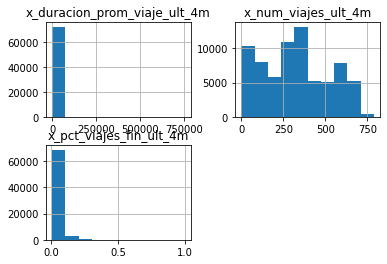

In [47]:
Xi[best].hist()

In [48]:
for v,li,ls in Xi[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    Xi[f'ex_{v}'] = ((Xi[v]<li)|(Xi[v]>ls)).astype(int)
Xi['ex_'] = Xi.filter(like='ex_').max(axis=1)
Xi['ex_'].value_counts(1)

0    0.946299
1    0.053701
Name: ex_, dtype: float64

In [49]:
Xi[um] = X[um] = Sn[um]

In [50]:
Xi = Xi.loc[Xi['ex_']==0].drop(Xi.filter(like='ex_').columns,axis=1).reset_index(drop=True)

array([[<AxesSubplot:title={'center':'x_duracion_prom_viaje_ult_4m'}>,
        <AxesSubplot:title={'center':'x_num_viajes_ult_4m'}>],
       [<AxesSubplot:title={'center':'x_pct_viajes_fin_ult_4m'}>,
        <AxesSubplot:>]], dtype=object)

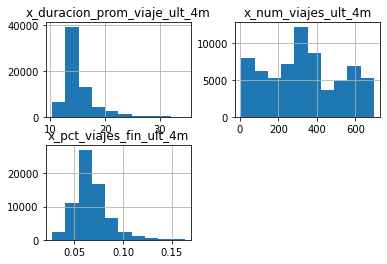

In [51]:
Xi[best].hist()

# Selección de Variables con mayor poder predictivo

In [52]:
Xi = Xi.merge(Sn[vart+um],on=um,how='inner')

In [53]:
sk = SelectKBest(k=len(best))
sk.fit(Xi[best],Xi[vart[0]])

SelectKBest(k=3)

In [54]:
pd.DataFrame(zip(best,sk.scores_),
             columns=['var','score']).set_index('var').sort_values(by='score',
                                                                   ascending=False).iplot(kind='bar',
                                                                                          color='purple')

In [55]:
best = [a for a,b in zip(best,sk.get_support()) if b]
best

['x_duracion_prom_viaje_ult_4m',
 'x_num_viajes_ult_4m',
 'x_pct_viajes_fin_ult_4m']

# Partición de entrenamiento

In [56]:
Xt, Xv, yt, yv = train_test_split(Xi[um+best],Xi[um+vart],train_size=0.7)
Xt.reset_index(drop=True,inplace=True)
Xv.reset_index(drop=True,inplace=True)
yt.reset_index(drop=True,inplace=True)
yv.reset_index(drop=True,inplace=True)

In [57]:
Xt.shape,Xv.shape

((47674, 5), (20433, 5))

# Análisis Discriminante

In [ ]:
modelo = LinearDiscriminantAnalysis()
modelo.fit(Xt[best],yt[vart[0]])

In [ ]:
St = Xt.merge(yt,on=um,how='inner')
Sv = Xv.merge(yv,on=um,how='inner')

In [ ]:
St['y^'] = modelo.predict(Xt[best]).astype(int)
Sv['y^'] = modelo.predict(Xv[best]).astype(int)

St['proba'] = modelo.predict_proba(Xt[best])[:,1]
Sv['proba'] = modelo.predict_proba(Xv[best])[:,1]

In [ ]:
print(accuracy_score(y_true=St[vart[0]],y_pred=St['y^']))
print(accuracy_score(y_true=Sv[vart[0]],y_pred=Sv['y^']))

print(roc_auc_score(y_true=St[vart[0]],y_score=modelo.predict_proba(Xt[best])[:,1]))
print(roc_auc_score(y_true=Sv[vart[0]],y_score=modelo.predict_proba(Xv[best])[:,1]))

# Regresión Logística

# Máquina Vector Soporte

In [63]:
hp = dict(C = np.arange(0.1,2,0.1),
          kernel =['linear', 'poly', 'rbf', 'sigmoid'],
          degree = range(2,3),
          probability = [True],
         )

In [58]:
modelo = SVC()
modelo.fit(Xt[best], yt[vart[0]])

SVC()

In [ ]:
grid = RandomizedSearchCV(param_distributions=hp,
                          n_iter=100,
                          cv=5,
                          scoring='accuracy',
                          n_jobs=-1,
                          verbose=True,
                          estimator=modelo)

In [ ]:
# Entrenamos nuestro grid 
grid.fit(Xt,yt)

In [ ]:
modelo = grid.best_estimator_
modelo

In [ ]:
modelo.fit(Xt,yt)

In [59]:
St = Xt.merge(yt,on=um,how='inner')
Sv = Xv.merge(yv,on=um,how='inner')

In [61]:
St['y^'] = modelo.predict(Xt[best]).astype(int)
Sv['y^'] = modelo.predict(Xv[best]).astype(int)

In [62]:
print(accuracy_score(y_true=St[vart[0]],y_pred=St['y^']))
print(accuracy_score(y_true=Sv[vart[0]],y_pred=Sv['y^']))

0.6758610563409825
0.6780208486272207


In [ ]:
print(confusion_matrix(y_pred=modelo.predict(St['y^']),y_true=St[vart[0]]))
print(confusion_matrix(y_pred=modelo.predict(Sv['y^']),y_true=Sv[vart[0]]))